# S-matrix validation with `jwave`
This notebook attempts to validate the S-matrix method of ultrasound simulation against a 1-D `jwave` simulation. 

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from logzero import logger

import scipy.signal as spsig
import numpy.fft as npft

# jwave imports
import jax.numpy as jnp
from jax import jit
from jwave import FourierSeries
from jwave.utils import show_field
import jax
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *

import itertools as itools
import functools as ftools

import Pulse as pulse
import plotutils as put
import smatrix as smat

import ipywidgets as widgets
from ipywidgets import interactive

In [2]:
np.random.seed( 42 )
%matplotlib widget

In [3]:
jax.config.update('jax_default_device', jax.devices('cpu')[0])
jax.config.update( 'jax_enable_x64', False )

# Simulation parameters
Ideally, you shouldn't have to change anything outside the following cell. 

In [4]:
soc = 0.3 # state of charge
domain_size_lam = 15 # in terms of number of pulse wavelengths
padding_fraction = 0.1
num_points_along_largest_dimension = 2000
cfl = 0.3 # Courant factor

materials = [ 'oil', 'steel', 'roll', 'anode', 'electrolyte', 'cathode', 'core' ]
speeds = [ 1440., 5500., 1041.865, (1.-soc)*1341. + soc*1443., 1497., (1.-soc)*1093. + soc*1136., 3410. ]
densities = [ 870., 7850., 1933.949, (1.-soc)*1909. + soc*1994., 1000., (1.-soc)*4172. + soc*3848., 0.129 ] 

stack_thickness = 7.5e-3
stack_definition = [ 0, 2, 3, 2, 0 ]

pulse_frequency = 2.25e6 # Hz
simulation_time = 100e-6 # seconds
pulse_order = 9

store_full_simulation = True

In [5]:
material_properties = { key: [ val1, val2 ] for key, val1, val2 in zip( materials, speeds, densities ) }
reflectivity = { 
    key: ( np.prod( material_properties[ key[0] ] ) - np.prod( material_properties[ key[1] ] ) ) / ( np.prod( material_properties[ key[0] ] ) + np.prod( material_properties[ key[1] ] ) )
    for key in list( itools.combinations( materials, 2 ) )
}

In [6]:
material_properties

{'oil': [1440.0, 870.0],
 'steel': [5500.0, 7850.0],
 'roll': [1041.865, 1933.949],
 'anode': [1371.6, 1934.5],
 'electrolyte': [1497.0, 1000.0],
 'cathode': [1105.8999999999999, 4074.7999999999993],
 'core': [3410.0, 0.129]}

In [7]:
reflectivity

{('oil', 'steel'): np.float64(-0.9436028792782897),
 ('oil', 'roll'): np.float64(-0.23322537632960863),
 ('oil', 'anode'): np.float64(-0.3585516538722605),
 ('oil', 'electrolyte'): np.float64(-0.0888064586515383),
 ('oil', 'cathode'): np.float64(-0.5649336312297029),
 ('oil', 'core'): np.float64(0.9992979955338002),
 ('steel', 'roll'): np.float64(0.9108246240556087),
 ('steel', 'anode'): np.float64(0.8842044450894404),
 ('steel', 'electrolyte'): np.float64(0.9329781518624641),
 ('steel', 'cathode'): np.float64(0.8109816928202526),
 ('steel', 'core'): np.float64(0.9999796231375466),
 ('roll', 'anode'): np.float64(-0.13676284394399266),
 ('roll', 'electrolyte'): np.float64(0.14747337437177244),
 ('roll', 'cathode'): np.float64(-0.3820453501314744),
 ('roll', 'core'): np.float64(0.999563461234954),
 ('anode', 'electrolyte'): np.float64(0.27861682945012817),
 ('anode', 'cathode'): np.float64(-0.2588049642744443),
 ('anode', 'core'): np.float64(0.9996684829413808),
 ('electrolyte', 'cathode

# Spatial domain

In [8]:
# calculating domain size
lam_all = [ s/pulse_frequency for s in speeds ]
lam_max = max(  lam_all )  # maximum wavelength
lam_min = min( lam_all )  # maximum wavelength
domain_size = domain_size_lam * lam_max
stack_location = 0.

buffer = 1. + padding_fraction

layer_size_fractions = np.random.rand( len( [ s for s in stack_definition if s ] ) ) # ignoring coupling medium
layer_size_fractions /= layer_size_fractions.sum()
layer_sizes = stack_thickness * layer_size_fractions


x_grid = buffer*np.linspace( 
    -domain_size/2., 
    domain_size/2., 
    np.round( buffer*num_points_along_largest_dimension ).astype( int ) 
)
dx = ( x_grid[1:] - x_grid[:-1] ).mean()
while dx > lam_min/10.: 
    num_points_along_largest_dimension *= 2
    logger.warning( 'dx step size too big. Recalculating...' )
    x_grid = np.linspace( -buffer*domain_size/2., buffer*domain_size/2., num_points_along_largest_dimension )
    dx = ( x_grid[1:] - x_grid[:-1] ).mean()

interface_locations = stack_location - stack_thickness/2. + np.cumsum( [0.] + list( layer_sizes ) )
density_map = np.empty( x_grid.shape ).astype( float )
speed_map = np.empty( x_grid.shape ).astype( float )
for n, mat_idx in enumerate( stack_definition[1:-1] ):
    spd, dens = material_properties[ materials[ mat_idx ] ]
    here = ( x_grid >= interface_locations[n] ) & ( x_grid < interface_locations[n+1] )
    density_map[ here ] = dens
    speed_map[ here ] = spd
density_map[ x_grid < interface_locations[0] ] = material_properties[ materials[ stack_definition[0] ] ][1]
speed_map[ x_grid < interface_locations[0] ] = material_properties[ materials[ stack_definition[0] ] ][0]
density_map[ x_grid >= interface_locations[-1] ] = material_properties[ materials[ stack_definition[-1] ] ][1]
speed_map[ x_grid >= interface_locations[-1] ] = material_properties[ materials[ stack_definition[-1] ] ][0]
pml_size = np.round( padding_fraction*domain_size/dx ).astype( int )//2

################################################################################

logger.info( f'λₘᵢₙ = {lam_min*1.e3:.3e} mm' )
logger.info( f'λₘₐₓ = {lam_max*1.e3:.3e} mm' )
logger.info( f'Domain size (without PML): {domain_size*1.e3:.3e} mm' )
logger.info( f'Grid points per λₘᵢₙ: {lam_min/dx}')
logger.info( f'PML size: {pml_size} pixels. ' )
logger.info( f'Grid step size: {dx*1.e3:.3e} mm' )
logger.info( f'Stack layer thicknesses: {layer_sizes*1.e3} mm' )
logger.info( f'Interface locations: {interface_locations*1.e3} mm' )

2025-09-11 00:01:35 - jwave [INFO]: λₘᵢₙ = 4.631e-01 mm
2025-09-11 00:01:35 - jwave [INFO]: λₘₐₓ = 2.444e+00 mm
2025-09-11 00:01:35 - jwave [INFO]: Domain size (without PML): 3.667e+01 mm
2025-09-11 00:01:35 - jwave [INFO]: Grid points per λₘᵢₙ: 25.245852727272716
2025-09-11 00:01:35 - jwave [INFO]: PML size: 100 pixels. 
2025-09-11 00:01:35 - jwave [INFO]: Grid step size: 1.834e-02 mm
2025-09-11 00:01:35 - jwave [INFO]: Stack layer thicknesses: [1.36544082 3.46596814 2.66859104] mm
2025-09-11 00:01:35 - jwave [INFO]: Interface locations: [-3.75       -2.38455918  1.08140896  3.75      ] mm


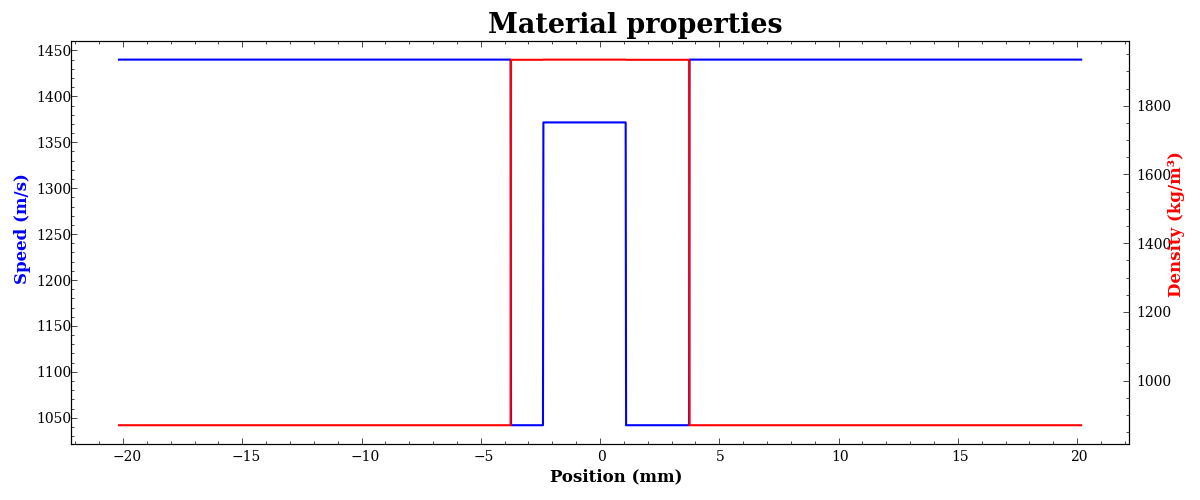

In [9]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots()
    ax.plot( x_grid*1.e3, speed_map, 'b' )
    ax.set_xlabel( 'Position (mm)' )
    ax.set_ylabel( 'Speed (m/s)', color='b' )

    ax2 = ax.twinx()
    ax2.plot( x_grid*1.e3, density_map, 'r' )
    ax2.set_ylabel( 'Density (kg/m³)', color='r' )
    plt.title( 'Material properties' )
    plt.tight_layout()


In [10]:
domain = Domain( ( x_grid.size, ), dx=( float( dx ), ) )
speed_field = FourierSeries( jnp.expand_dims( speed_map, axis=-1 ), domain=domain )
density_field = FourierSeries( jnp.expand_dims( density_map, axis=-1 ), domain=domain )

speed_field_bare = FourierSeries( jnp.expand_dims( material_properties[ 'oil' ][0]*np.ones( speed_map.size ), axis=-1 ), domain=domain )
density_field_bare = FourierSeries( jnp.expand_dims( material_properties[ 'oil' ][1]*np.ones( speed_map.size ), axis=-1 ), domain=domain )


medium = Medium(domain=domain, sound_speed=speed_field, density=density_field, pml_size=int( pml_size ), attenuation=0.95 )
medium_bare = Medium(domain=domain, sound_speed=speed_field_bare, density=density_field_bare, pml_size=int( pml_size ), attenuation=0.95 )

# Time domain

2025-09-11 00:01:36 - jwave [INFO]: Pulse period: 4.444e-01 µs
2025-09-11 00:01:36 - jwave [INFO]: Time step size: 3.821e-03 µs
2025-09-11 00:01:36 - jwave [INFO]: Sample points per period: 116.31


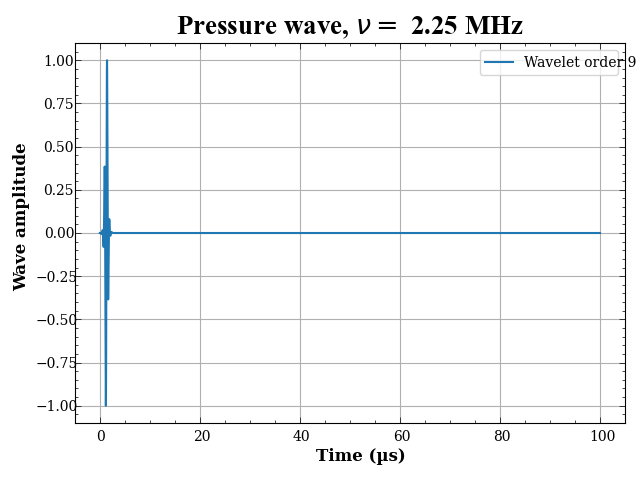

In [11]:
period = 1. / pulse_frequency
time_axis = TimeAxis.from_medium( medium, cfl=cfl )
time_axis.t_end = simulation_time
logger.info( f'Pulse period: {period*1.e6:.3e} µs' )
logger.info( f'Time step size: {time_axis.dt*1.e6:.3e} µs' )
logger.info( f'Sample points per period: {period/time_axis.dt:.2f}' )

t = time_axis.dt * np.arange( int( time_axis.Nt ) )

# craft a pulse of the correct frquency
test_spread = period/4.
pulse_location = 3. * period # this is a bit of trial and error
t_shift = t - pulse_location
chi = t_shift / test_spread
test_pulse = pulse.MysteryPulse( chi, 0., 1., order=pulse_order )
peaks = spsig.find_peaks( test_pulse )[0] # peak locations only
T = ( t_shift[ peaks[1:] ] - t_shift[ peaks[:-1] ] ).mean()
new_spread = test_spread * ( period / T )
init = pulse.MysteryPulse( t_shift, 0., new_spread, order=pulse_order ) # this is the final pulse of desired frequency
init /= init.max()

with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure()
    plt.plot( t/1.e-6, init, label=f'Wavelet order {pulse_order}' )
    plt.grid()
    plt.legend()
    plt.xlabel( 'Time (µs)' )
    plt.ylabel( 'Wave amplitude' )
    plt.title( f'Pressure wave, $\\nu =$ {pulse_frequency/1.e6:.2f} MHz' )
    plt.tight_layout()

sources = Sources( 
    positions=( [ np.argmin( np.abs( x_grid + 17.5e-3 ) ) ], ), 
    signals=jnp.stack( [ init ] ), 
    dt = time_axis.dt, 
    domain=domain
)

# Sensors

In [12]:
xloc = [ np.argmin( np.abs( x_grid - interface_locations[n] ) ) for n in [ 0, -1 ] ]
sensor_positions = ( xloc, )
sensors = Sensors( positions=sensor_positions )

In [13]:
if store_full_simulation:
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources )
    @jit
    def compiled_simulator_bare( sources ):
        return simulate_wave_propagation( medium_bare, time_axis, sources=sources )
else: 
    @jit
    def compiled_simulator( sources ):
        return simulate_wave_propagation( medium, time_axis, sources=sources, sensors=sensors )
    @jit
    def compiled_simulator_bare( sources ):
        return simulate_wave_propagation( medium_bare, time_axis, sources=sources, sensors=sensors )


# Run the simulation

In [14]:
pressure = compiled_simulator( sources=sources )
pres = np.squeeze( pressure.on_grid ) if store_full_simulation else np.squeeze( pressure )
logger.info( f'Simulation size: {pres.shape}' )
pmax = min( np.abs( pres.min() ), np.abs( pres.max() ) )
pmin = -pmax

# run the simulation without the structure to obtain the incident wave
pressure_bare = compiled_simulator_bare( sources=sources )
pres_bare = np.squeeze( pressure_bare.on_grid ) if store_full_simulation else np.squeeze( pressure_bare )

2025-09-11 00:01:37 - jwave [INFO]: Simulation size: (26170, 2200)


In [15]:
print( pmin, pmax )

-1.4766619 1.4766619


interactive(children=(IntSlider(value=0, description='Frame:', max=26169), Output()), _dom_classes=('widget-in…

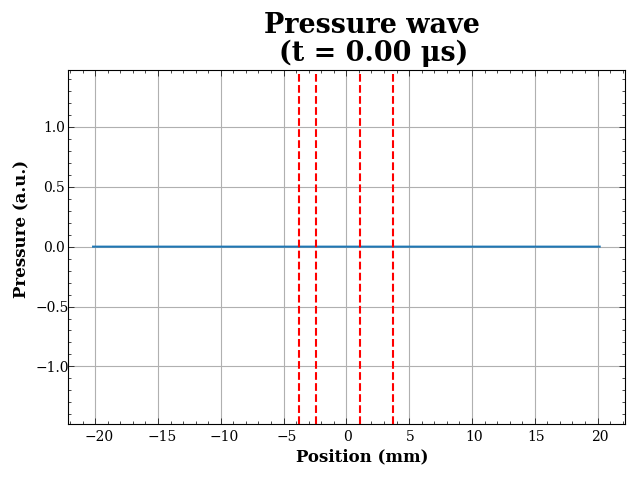

In [16]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    fig = plt.figure()
    ax = fig.subplots()
    line, = ax.plot( x_grid*1.e3, pres[0] )
    ax.set_ylim( [ pmin, pmax ] )
    ax.grid()
    ax.set_xlabel( 'Position (mm)' )
    ax.set_ylabel( 'Pressure (a.u.)' )
    titl = ax.set_title( f'Pressure wave\n(t = 0.00 μs)' )
    for loc in interface_locations: 
        ax.vlines( x=loc*1.e3, ymin=pmin, ymax=pmax, color='r', linestyle='--' )
    plt.tight_layout()

def Update( n ):
    line.set_ydata( pres[n] )
    titl.set_text( f'Pressure wave\n(t = {t[n]/1.e-6:.2f} μs)' )
    fig.canvas.draw_idle()

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=pres.shape[0] - 1,
    step=1,
    description='Frame:',
    continuous_update=True
)
interactive_plot = interactive( Update, n=slider )
display( interactive_plot )

# Post-simulation analysis

In [17]:
wave_incident = pres_bare[:,xloc[0]]
wave_sensor1 = pres[:,xloc[0]] 
wave_transmitted = pres[:,xloc[1]]
wave_reflected = wave_sensor1 - wave_incident

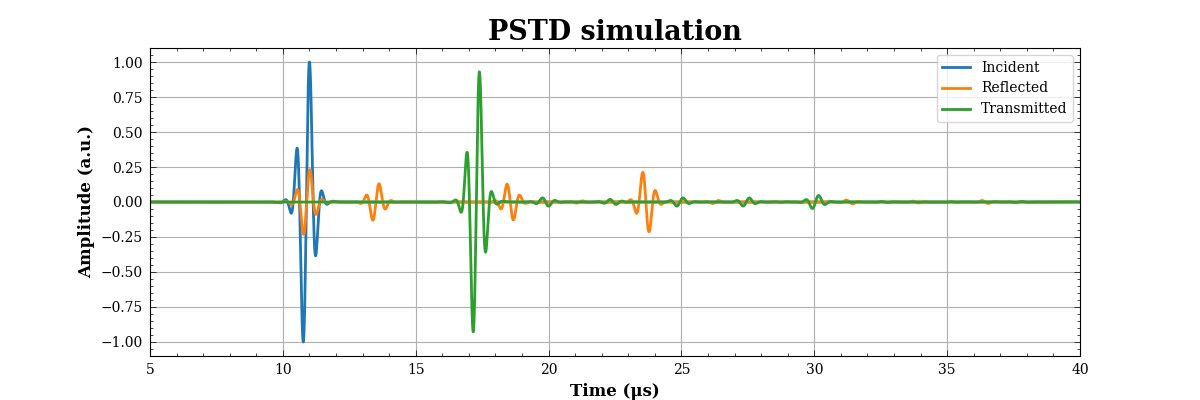

In [18]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 4 ) )
    plt.plot( t/1.e-6, wave_incident, label='Incident', linewidth=2 )
    plt.plot( t/1.e-6, wave_reflected, label='Reflected', linewidth=2 )
    plt.plot( t/1.e-6, wave_transmitted, label='Transmitted', linewidth=2 )
    plt.xlim( [ 5., 40. ] )
    plt.xlabel( 'Time (μs)' )
    plt.ylabel( 'Amplitude (a.u.)' )
    plt.grid()
    plt.legend()
    plt.title( 'PSTD simulation' )

# Harmonic analysis

In [19]:
freqs = npft.fftfreq( len( wave_incident ), d=time_axis.dt )
freqs = freqs[ freqs >= 0. ] 
df = ( freqs[1:] - freqs[:-1] ).mean()
freqs = np.array( list( freqs ) + [ freqs[-1] + df ] )

fwav_inc = npft.rfft( wave_incident, norm='ortho' )
fwav_ref = npft.rfft( wave_reflected, norm='ortho' )
fwav_trn = npft.rfft( wave_transmitted, norm='ortho' )

logger.info( f'Fourier components\t= {freqs.size}' )
logger.info( f'Frequency step\t= {df:.3e}' )

2025-09-11 00:01:40 - jwave [INFO]: Fourier components	= 13086
2025-09-11 00:01:40 - jwave [INFO]: Frequency step	= 1.000e+04


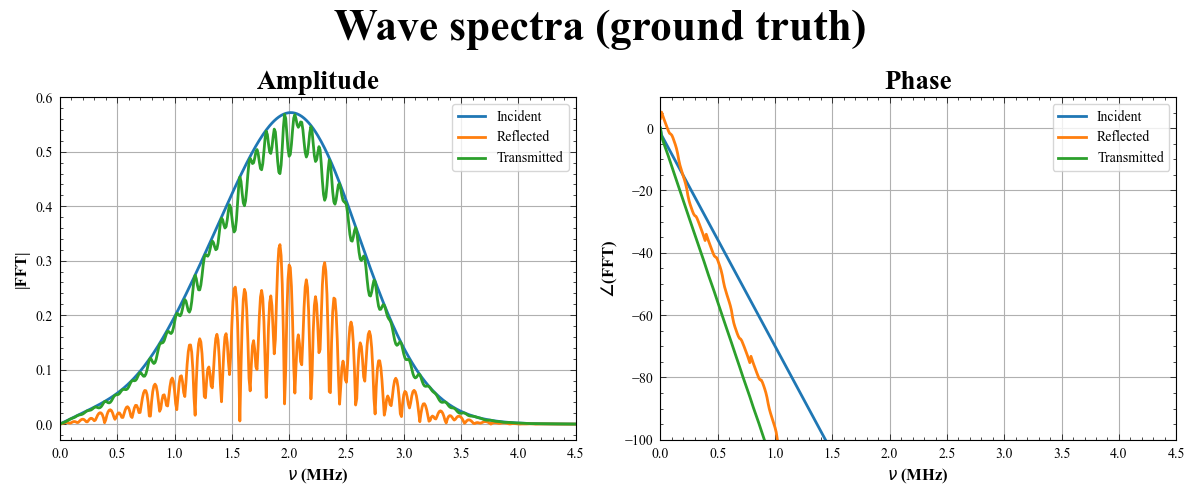

2025-09-11 00:01:40 - jwave [INFO]: Incident spectrum total energy = 5.8476383e+04
2025-09-11 00:01:40 - jwave [INFO]: Reflected spectrum total energy = 7.7617960e+03
2025-09-11 00:01:40 - jwave [INFO]: Transmitted spectrum total energy = 5.0707070e+04
2025-09-11 00:01:40 - jwave [INFO]: Energy conservation error = 1.2854727e-02%


In [20]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[0].plot( freqs/1.e6, np.abs( wav ), label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( '$\\nu$ (MHz)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 2./( period/1.e-6 ) ] )
    
    # ax.figure( figsize=( 12, 5 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[1].plot( freqs/1.e6, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    # ax[1].set_xlim( [ 0., 3/pulse_width ] )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( '$\\nu$ (MHz)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra (ground truth)' )
    plt.tight_layout()
    plt.show()

Ef = []
for n, ( wav, lbl ) in enumerate( zip( [ fwav_inc, fwav_ref, fwav_trn ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2.*np.pi ) # trapezoidal integration
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )


## S-matrix reconstruction

In [21]:
inputs = np.concatenate( [ arr[np.newaxis,:] for arr in [ fwav_inc, np.zeros( fwav_inc.shape ) ] ], axis=0 )
speed, density = zip( *[ [ speeds[n], densities[n] ] for n in stack_definition ] )
Z = np.array( [ s*d for s, d in zip( speed, density ) ] )

# build propagator
if len( stack_definition ) == 3:
    logger.warning( 'Single stack. ' )
    propagator = ftools.partial( smat.SMatrix, length=stack_thickness, speed=float( speed[1] ), Z=Z, field='pressure' )
else: 
    logger.warning( 'Composite stack. ' )
    length = [b-a for b, a in zip( interface_locations[1:], interface_locations[:-1] ) ]
    propagators = [ 
        ftools.partial( smat.SMatrix, length=l, speed=s, Z=Z[n:n+3], field='pressure' )
        for n, ( l, s ) in enumerate( zip( length, speed[1:-1] ) )
    ]

2025-09-11 00:01:40 - jwave [WARNING]: Composite stack. 


In [22]:
# all_outputs = np.empty( input.shape ).astype( complex )
all_outputs = np.zeros( ( 2, freqs.size ), dtype=complex )
start_time = time.time()
for n, omega_test in enumerate( 2.*np.pi*freqs ):
    
    if len( stack_definition ) == 3: 
        S = propagator( omega=omega_test ).S
        output = S @ inputs[:,n][:,np.newaxis]
    else:
        S = ftools.reduce( lambda x, y: x*y, [ prop( omega=omega_test ) for prop in propagators ] )
        # print( np.abs( np.linalg.eig( np.conj( S.S.T ) @ S.S )[0] ) )
        output = S.S @ inputs[:,n][:,np.newaxis]

    # all_outputs.append( output )
    all_outputs[:,n] = output.squeeze()

elapsed_time = time.time() - start_time
logger.info( f'S-matrix simulation took {elapsed_time:.6f} seconds to reconstruct {freqs.size} Fourier components. ' )

# all_outputs = np.concatenate( all_outputs, axis=1 )

2025-09-11 00:01:41 - jwave [INFO]: S-matrix simulation took 0.651246 seconds to reconstruct 13086 Fourier components. 


2025-09-11 00:01:41 - jwave [INFO]: Incident spectrum total energy = 5.8476383e+04
2025-09-11 00:01:41 - jwave [INFO]: Reflected spectrum total energy = 1.2741312e+04
2025-09-11 00:01:41 - jwave [INFO]: Transmitted spectrum total energy = 4.5735072e+04
2025-09-11 00:01:41 - jwave [INFO]: Energy conservation error = 2.8268664e-06%
2025-09-11 00:01:41 - jwave [INFO]: Energy conservation error (in multiples of machine zero) = 127310746.228656440973282


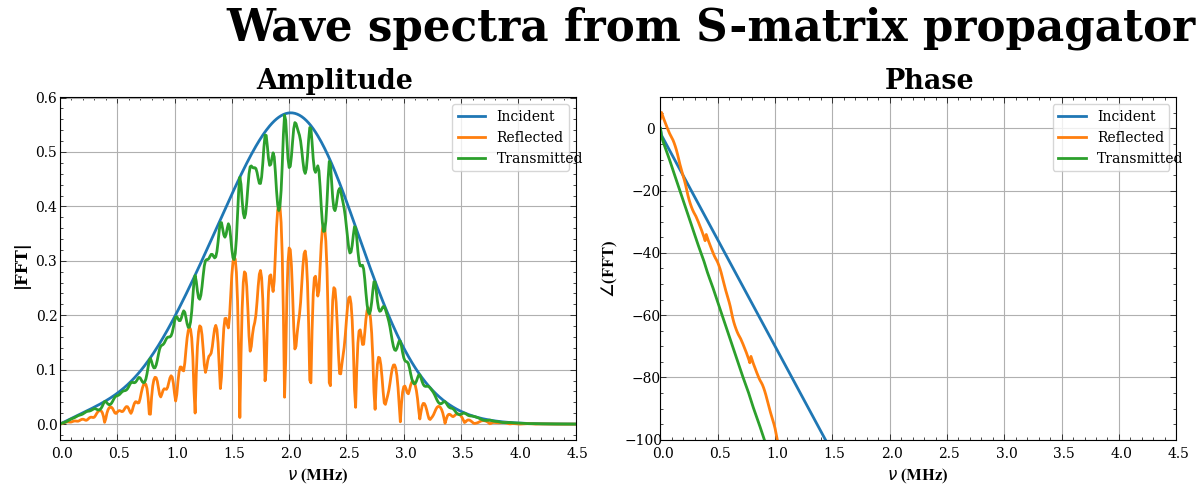

In [23]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    ax = plt.figure( figsize=( 12, 5 ) ).subplots( 1, 2, sharex=True )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[0].plot( freqs/1.e6, np.abs( wav )[:freqs.size], label=lbl, linewidth=2 )
    # ax[0].set_xlim( [ 0., 35. ] )
    ax[0].grid()
    ax[0].legend()
    ax[0].set_title( 'Amplitude' )
    ax[0].set_xlabel( '$\\nu$ (MHz)' )
    ax[0].set_ylabel( '|FFT|' )
    ax[0].set_xlim( [ 0., 2./( period/1.e-6 ) ] )
    
    for wav, lbl in zip( [ fwav_inc, all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
        ax[1].plot( freqs/1.e6, np.unwrap( np.angle( wav ) )[:freqs.size], label=lbl, linewidth=2 )
    ax[1].set_ylim( [ -100., 10. ] )
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title( 'Phase' )
    ax[1].set_xlabel( '$\\nu$ (MHz)' )
    ax[1].set_ylabel( '$\\angle$(FFT)' )

    plt.suptitle( 'Wave spectra from S-matrix propagator' )
    plt.tight_layout()
    
df = ( freqs[1:] - freqs[:-1] ).mean()
Ef = []
for wav, lbl in zip( [ fwav_inc[:-1], all_outputs[1], all_outputs[0] ], [ 'Incident', 'Reflected', 'Transmitted' ] ):
    power = np.abs( wav )**2
    temp = df*( 0.5*( power[0] + power[-1] ) + power[1:-1].sum() ) / ( 2. * np.pi )
    logger.info( f'{lbl} spectrum total energy = {temp:.7e}' )
    Ef.append( temp )
dE_E = np.abs(Ef[1]+Ef[2]-Ef[0])/Ef[0]
logger.info( f'Energy conservation error = {dE_E*100.:.7e}%' )
logger.info( f'Energy conservation error (in multiples of machine zero) = {dE_E/np.finfo( float ).eps:.15f}' )

plt.show()

# Simulated waveforms from S-matrix
Compare these to the simulated waveforms plotted earlier. 

In [24]:
back = npft.irfft( fwav_inc, norm='ortho' )
back_r = npft.irfft( all_outputs[1], norm='ortho' )
back_t = npft.irfft( all_outputs[0], norm='ortho' )

2025-09-11 00:01:42 - jwave [INFO]: Incident energy	= 2.808e-07
2025-09-11 00:01:42 - jwave [INFO]: Reflected energy	= 6.118e-08
2025-09-11 00:01:42 - jwave [INFO]: Transmitted energy	= 2.196e-07


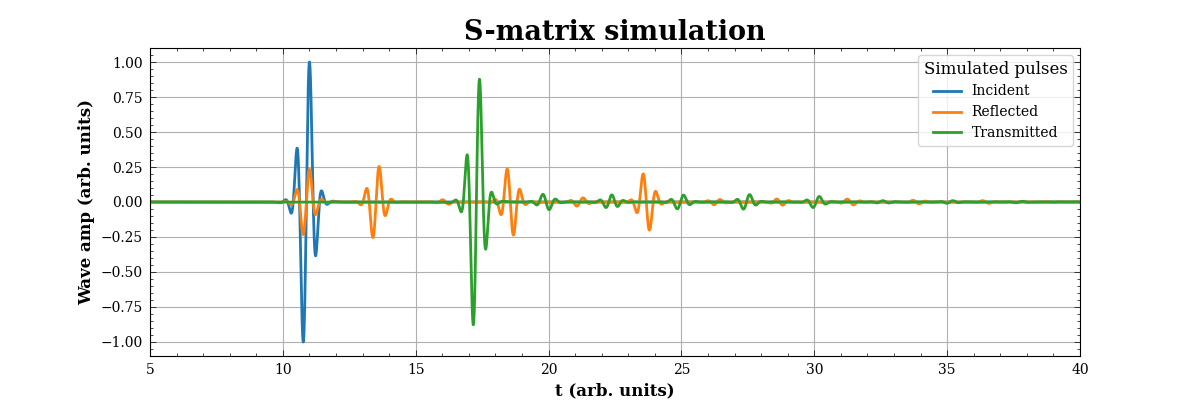

In [25]:
with plt.style.context( '~/Templates/custom.mplstyle' ):
    plt.figure( figsize=( 12, 4 ) )
    for n, ( wav, lbl ) in enumerate( zip( [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        E = time_axis.dt*( np.abs( wav )**2 ).sum()
        # energy.append( E )
        logger.info( f'{lbl} energy\t= {E:.3e}' )
        plt.plot( t[:wav.size]/1.e-6, wav, label=lbl, linewidth=2 )
    plt.xlim( [ 5., 40. ] )
    plt.grid()
    plt.legend( title='Simulated pulses' )
    plt.title( 'S-matrix simulation' )
    plt.xlabel( 't (arb. units)' )
    plt.ylabel( 'Wave amp (arb. units)' )
    

# Ert = energy[1]+energy[2]
# error = np.abs( Ert-energy[0] )/energy[0]
# logger.info( f'Energy conservation error: {error*100.:.7f}%' )

# plt.show()



# Comparison plots

2025-09-11 00:01:42 - jwave [INFO]: Incident error: 1.487e-08
2025-09-11 00:01:42 - jwave [INFO]: Reflected error: 1.866e-03
2025-09-11 00:01:42 - jwave [INFO]: Transmitted error: 9.888e-04


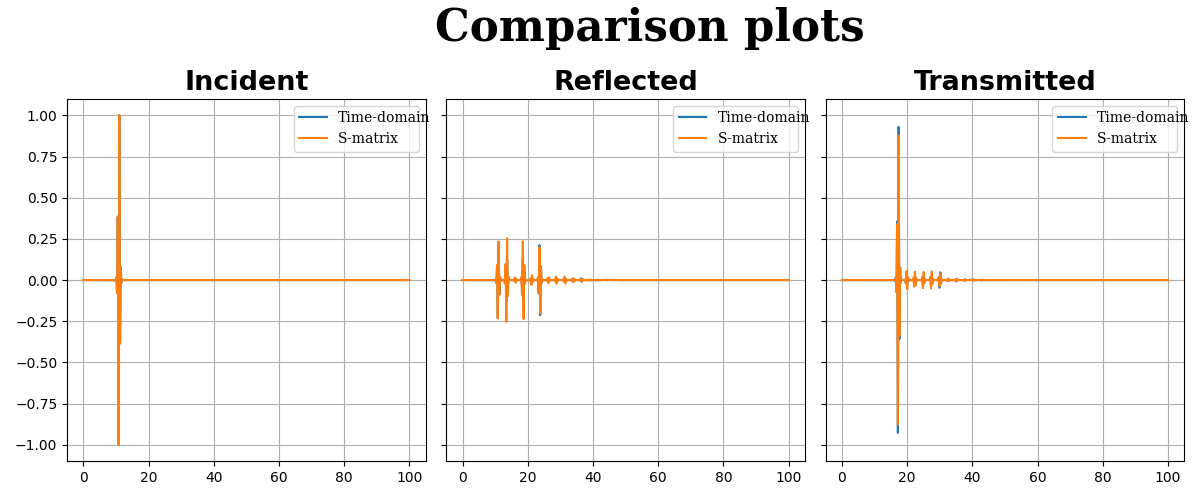

In [26]:
fig = plt.figure( figsize=( 12, 5 ) )
ax = fig.subplots( 1, 3, sharex=True, sharey=True )

with plt.style.context( '~/Templates/custom.mplstyle' ):
    for n, ( wav1, wav2, lbl ) in enumerate( zip( [ wave_incident, wave_reflected, wave_transmitted ], [ back, back_r, back_t ], [ 'Incident', 'Reflected', 'Transmitted' ] ) ):
        ax[n].plot( t/1.e-6, wav1, label='Time-domain' )
        ax[n].plot( t/1.e-6, wav2, label='S-matrix' )
        ax[n].grid()
        ax[n].legend()
        ax[n].set_title( lbl )
        logger.info( f'{lbl} error: {np.abs( wav1-wav2 ).sum()/np.array( wav1 ).size:.3e}' )
    fig.suptitle( 'Comparison plots' )
    fig.tight_layout()
